# Use a model trained on 2020 data to predict for 2019 train

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Subset, DataLoader
from argparse import Namespace
%matplotlib inline

In [2]:
torch.cuda.is_available()

True

In [3]:
from cassava.lmdb_dataset import *
from cassava.utils import *
from cassava.transforms import get_test_transforms
from cassava.models.model import LeafDoctorModel
from cassava.pipelines.train_model.nodes import score_model
from cassava.pipelines.train_model.nodes import split_data, train_model

In [4]:
parameters = context.catalog.load('parameters')

2020-12-24 14:42:54,675 - kedro.io.data_catalog - INFO - Loading data from `parameters` (MemoryDataSet)...


In [5]:
parameters

{'seed': 42,
 'cv_splits': 4,
 'cv_models_dir': 'data/06_models/cv_folds',
 'validation_size': 0.15,
 'data_loader_workers': 6,
 'classifier': {'gpus': -1,
  'batch_size': 24,
  'max_epochs': 100,
  'max_steps': 0,
  'auto_lr_find': 0,
  'lr': 0.001,
  'weight_decay': 0.0001,
  'early_stop_patience': 4,
  'reduce_lr_on_pleteau_patience': 2,
  'save_top_k_checkpoints': 1,
  'checkpoints_dir': 'data/06_models/classifier/checkpoints',
  'amp_level': 'O2',
  'precision': 16},
 'byol': {'gpus': -1,
  'batch_size': 6,
  'accumulate_grad_batches': 1,
  'max_epochs': 100,
  'max_steps': 0,
  'auto_lr_find': 0,
  'lr': 0.001,
  'reduce_lr_on_pleteau_patience': 1,
  'weight_decay': 0.0001,
  'limit_train_batches': 100,
  'limit_val_batches': 1,
  'early_stop_patience': 3,
  'amp_level': '02',
  'precision': 16,
  'on_test': {'lr': 0.0001,
   'auto_lr_find': 0,
   'max_epochs': 5,
   'early_stop_patience': 1}},
 'eval': {'batch_size': 16}}

In [7]:
train = context.catalog.load('train')

2020-12-24 14:43:01,102 - kedro.io.data_catalog - INFO - Loading data from `train` (ImageOneFolderDataSet)...


In [9]:
duplicates = context.catalog.load('duplicates')

2020-12-24 14:43:06,526 - kedro.io.data_catalog - INFO - Loading data from `duplicates` (CSVDataSet)...


In [13]:
train_2020_indices = np.array(range(len(train)))[train.sources == 'train_2020']

In [14]:
train_2019_indices = np.array(range(len(train)))[train.sources == 'train_2019']

In [15]:
assert len(train_labels) == len(train_2020_indices), (len(train_labels), len(train_2020_indices))

In [16]:
train_2020 = DatasetFromSubset(Subset(train, indices=train_2020_indices))

In [52]:
train_2019 = DatasetFromSubset(Subset(train, indices=train_2019_indices))

In [20]:
pd.Series(train.labels[train_2020_indices]).value_counts(normalize=True)[[0, 1, 2, 3, 4]]

0    0.050760
1    0.102314
2    0.111521
3    0.615004
4    0.120402
dtype: float64

In [21]:
pd.Series(train.labels[train_2019_indices]).value_counts(normalize=True)[[0, 1, 2, 3, 4]]

0    0.082034
1    0.260685
2    0.127810
3    0.466275
4    0.063196
dtype: float64

In [22]:
unnorm = Unnormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

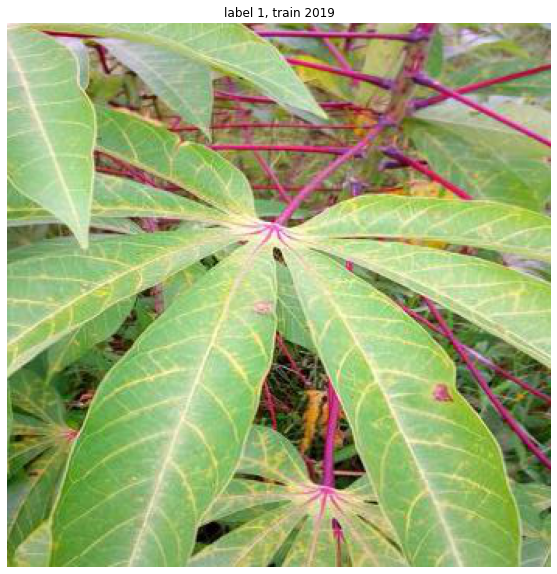

In [25]:
idx = np.random.choice(train_2019_indices)
img, label = train[idx]
plt.figure(figsize=(10, 10))
plot_image(unnorm(get_test_transforms()(image=img)['image']), label=f'label {label}, train 2019')
plt.show()

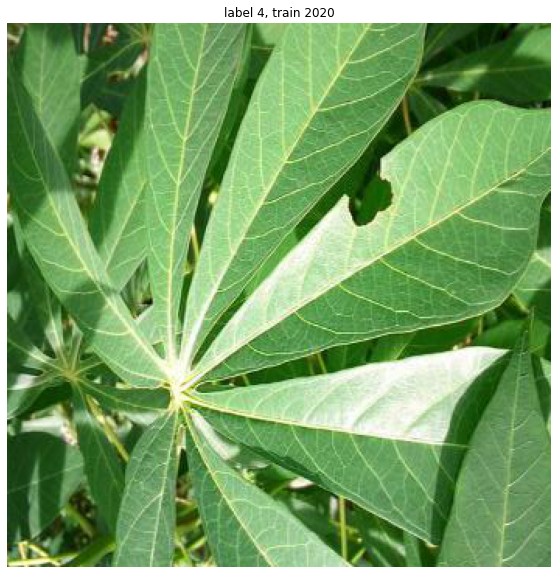

In [26]:
idx = np.random.choice(train_2020_indices)
img, label = train[idx]
plt.figure(figsize=(10, 10))
plot_image(unnorm(get_test_transforms()(image=img)['image']), label=f'label {label}, train 2020')

# Train model on 2020 data

In [28]:
train_indices, val_indices = split_data(train_2020, parameters)

In [29]:
assert not set(train_indices).intersection(train_2019_indices)

In [41]:
hparams = Namespace(**parameters['classifier'])
model = LeafDoctorModel(hparams)

In [42]:
# model = LeafDoctorModel(hparams).load_from_checkpoint(checkpoint_path='../data/06_models/classifier/checkpoints/epoch=9_val_acc=0.8779.ckpt')

In [43]:
model = train_model(model, train_2020, train_indices, val_indices, parameters)

GPU available: True, used: True


2020-12-24 14:47:17,408 - lightning - INFO - GPU available: True, used: True


TPU available: False, using: 0 TPU cores


2020-12-24 14:47:17,410 - lightning - INFO - TPU available: False, using: 0 TPU cores


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


2020-12-24 14:47:17,411 - lightning - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using native 16bit precision.


2020-12-24 14:47:17,413 - lightning - INFO - Using native 16bit precision.



  | Name  | Type         | Params
---------------------------------------
0 | trunk | EfficientNet | 4.0 M 


2020-12-24 14:47:17,654 - lightning - INFO - 
  | Name  | Type         | Params
---------------------------------------
0 | trunk | EfficientNet | 4.0 M 


/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
Epoch 0: val_acc reached 0.00000 (best 0.00000), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=0_val_acc=0.0000.ckpt as top 1


2020-12-24 14:52:31,628 - lightning - INFO - Epoch 0: val_acc reached 0.00000 (best 0.00000), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=0_val_acc=0.0000.ckpt as top 1

2020-12-24 14:52:31,886 - root - INFO - Training finished


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

In [45]:
score, preds = score_model(model, train_2020, val_indices, parameters)
print('Val score', score)

2020-12-24 14:52:35,882 - root - INFO - Scoring model


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f342392fa60>
Traceback (most recent call last):
  File "/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.8/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


2020-12-24 14:53:04,388 - root - INFO - Validation scores:
{'accuracy': 0.7962616822429907, 'f1_score': 0.795869630875576}
Val score {'accuracy': 0.7962616822429907, 'f1_score': 0.795869630875576}


In [49]:
score, preds = score_model(model, train, train_2019_indices, parameters)
print('2019 score', score)

2020-12-24 14:53:45,011 - root - INFO - Scoring model



2020-12-24 14:54:00,796 - root - INFO - Validation scores:
{'accuracy': 0.6574843022078185, 'f1_score': 0.6341487176127487}
2019 score {'accuracy': 0.6574843022078185, 'f1_score': 0.6341487176127487}


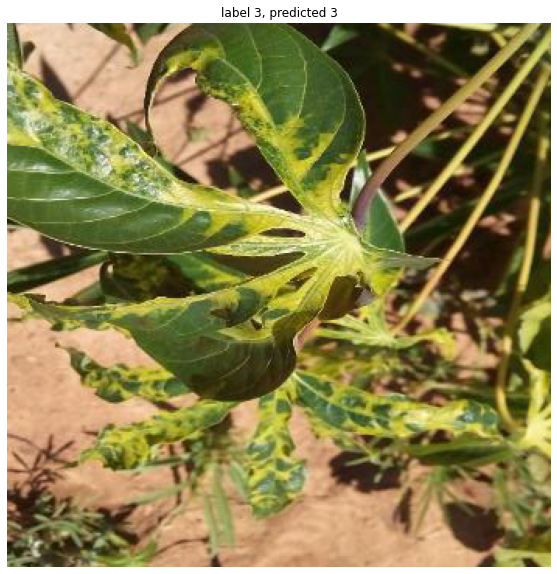

In [50]:
idx = np.random.choice(train_2019_indices)
img, label = train[idx]
predicted = preds[np.argwhere(train_2019_indices == idx)[0][0]]
plt.figure(figsize=(10, 10))
plot_image(unnorm(get_test_transforms()(image=img)['image']), label=f'label {label}, predicted {predicted}')
plt.show()

# Train model on 2019 train

In [51]:
train_indices, val_indices = split_data(train_2019, parameters)

In [57]:
hparams = Namespace(**parameters['classifier'])
model = LeafDoctorModel(hparams)

In [58]:
model = train_model(model, train_2019, train_indices, val_indices, parameters)

/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Checkpoint directory data/06_models/classifier/checkpoints exists and is not empty. With save_top_k=1, all files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)
GPU available: True, used: True


2020-12-24 14:55:13,680 - lightning - INFO - GPU available: True, used: True


TPU available: False, using: 0 TPU cores


2020-12-24 14:55:13,681 - lightning - INFO - TPU available: False, using: 0 TPU cores


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


2020-12-24 14:55:13,684 - lightning - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using native 16bit precision.


2020-12-24 14:55:13,686 - lightning - INFO - Using native 16bit precision.



  | Name  | Type         | Params
---------------------------------------
0 | trunk | EfficientNet | 4.0 M 


2020-12-24 14:55:13,891 - lightning - INFO - 
  | Name  | Type         | Params
---------------------------------------
0 | trunk | EfficientNet | 4.0 M 


Epoch 0: val_acc reached 0.81781 (best 0.81781), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=0_val_acc=0.8178.ckpt as top 1


2020-12-24 14:57:16,215 - lightning - INFO - Epoch 0: val_acc reached 0.81781 (best 0.81781), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=0_val_acc=0.8178.ckpt as top 1


Epoch 1: val_acc reached 0.83131 (best 0.83131), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=1_val_acc=0.8313.ckpt as top 1


2020-12-24 14:59:20,799 - lightning - INFO - Epoch 1: val_acc reached 0.83131 (best 0.83131), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=1_val_acc=0.8313.ckpt as top 1


Epoch 2: val_acc reached 0.83671 (best 0.83671), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=2_val_acc=0.8367.ckpt as top 1


2020-12-24 15:01:25,210 - lightning - INFO - Epoch 2: val_acc reached 0.83671 (best 0.83671), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=2_val_acc=0.8367.ckpt as top 1


Epoch 3: val_acc reached 0.85695 (best 0.85695), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=3_val_acc=0.8570.ckpt as top 1


2020-12-24 15:03:32,338 - lightning - INFO - Epoch 3: val_acc reached 0.85695 (best 0.85695), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=3_val_acc=0.8570.ckpt as top 1
Epoch     4: reducing learning rate of group 0 to 1.0000e-04.


Epoch 4: val_acc reached 0.86640 (best 0.86640), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=4_val_acc=0.8664.ckpt as top 1


2020-12-24 15:05:37,950 - lightning - INFO - Epoch 4: val_acc reached 0.86640 (best 0.86640), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=4_val_acc=0.8664.ckpt as top 1


Epoch 5: val_acc reached 0.87584 (best 0.87584), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=5_val_acc=0.8758.ckpt as top 1


2020-12-24 15:07:39,920 - lightning - INFO - Epoch 5: val_acc reached 0.87584 (best 0.87584), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=5_val_acc=0.8758.ckpt as top 1


Epoch 6: val_acc reached 0.88664 (best 0.88664), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=6_val_acc=0.8866.ckpt as top 1


2020-12-24 15:09:42,164 - lightning - INFO - Epoch 6: val_acc reached 0.88664 (best 0.88664), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=6_val_acc=0.8866.ckpt as top 1
Epoch     7: reducing learning rate of group 0 to 1.0000e-05.


Epoch 7: val_acc reached 0.88934 (best 0.88934), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=7_val_acc=0.8893.ckpt as top 1


2020-12-24 15:11:44,445 - lightning - INFO - Epoch 7: val_acc reached 0.88934 (best 0.88934), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=7_val_acc=0.8893.ckpt as top 1


/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
Epoch 8: val_acc was not in top 1


2020-12-24 15:13:10,697 - lightning - INFO - Epoch 8: val_acc was not in top 1

2020-12-24 15:13:10,766 - root - INFO - Training finished


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


In [59]:
score, preds = score_model(model, train_2019, val_indices, parameters)
print('Val score', score)

2020-12-24 15:13:11,136 - root - INFO - Scoring model



2020-12-24 15:13:14,229 - root - INFO - Validation scores:
{'accuracy': 0.8893387314439946, 'f1_score': 0.8909246833760365}
Val score {'accuracy': 0.8893387314439946, 'f1_score': 0.8909246833760365}


In [60]:
score, preds = score_model(model, train, train_2020_indices, parameters)
print('2020 score', score)

2020-12-24 15:13:14,237 - root - INFO - Scoring model



2020-12-24 15:15:02,333 - root - INFO - Validation scores:
{'accuracy': 0.7813975227856976, 'f1_score': 0.7923299782646126}
2020 score {'accuracy': 0.7813975227856976, 'f1_score': 0.7923299782646126}


In [61]:
print('2020 score', score)

2020 score {'accuracy': 0.7813975227856976, 'f1_score': 0.7923299782646126}
